# [ Chapter 5 - Knowledge Graph Learning ]
# Automatic Extraction of Knowledge Graphs from Content

In [1]:
import sys
sys.path.append('..')
from aips import *
import os, re, string, pandas, spacy, spacy_experimental

In [2]:
import spacy
lang_model = spacy.load('en_core_web_sm')
coref_model = spacy.load('en_coreference_web_trf')

def resolve_coreferences(doc):
    token_mention_mapper = {}
    output_string = ""
    clusters = [
        val for key, val in doc.spans.items() if key.startswith("coref_cluster")
    ]

    for cluster in clusters:
        first_mention = cluster[0]
        for mention_span in list(cluster)[1:]:
            token_mention_mapper[mention_span[0].idx] = first_mention.text + mention_span[0].whitespace_
            for token in mention_span[1:]:
                token_mention_mapper[token.idx] = ""

    for token in doc:
        if token.idx in token_mention_mapper:
            output_string += token_mention_mapper[token.idx]
        else:
            output_string += token.text + token.whitespace_

    return output_string

def get_sentences(doc):
    return [lang_model(s.text.strip()) for s in doc.sents if s.text.strip()]

def resolve_facts(sentence):
    entities = get_candidate_entities(sentence)
    retokenize_with_entities(sentence, entities)
    print(f'sentence: {sentence}')

    syntactic_dependency = [token.dep_ for token in sentence]
    print(f'syntactic_dependency_parse: {syntactic_dependency}')
    
    facts = list()
    for token in sentence:
        facts += find_facts_for_token(token, sentence)
        
    return facts


def find_facts_for_token(token, sentence):
    facts = list()
    if token.dep_ in ('obj', 'dobj', 'nsubjpass'):  #object dep labels                  
        subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj', 'pobj')]  # subject for those objects

        if subject:
            subject = subject[0]
            relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                
            if relation:
                relation = relation[0]
                if relation.nbor(1).pos_ in ('ADP', 'AUXPASS','PART'):  
                    relation = ' '.join((str(relation),
                            str(relation.nbor(1))))
            else:
                relation = 'unknown'
            subject, subject_type = clean_up_entity(subject, sentence)
            token, object_type = clean_up_entity(token, sentence)
            facts.append([str(subject), str(relation), str(token)])
            print('---------------------')
            
    return facts

def get_candidate_entities(sentence):
    entities = list(sentence.ents)
    nouns = list(sentence.noun_chunks)
    deduped_candidate_entities = spacy.util.filter_spans(entities + nouns)
    return deduped_candidate_entities

def retokenize_with_entities(sentence, spans):
    with sentence.retokenize() as retokenizer:
        [retokenizer.merge(span) for span in spans]

def clean_up_entity(entity, sentence):
    entity_type = entity.ent_type_
    if entity_type == '':
        entity_type = 'NOUN_PHRASE'
        entity = ' '.join(str(token.text) for token in
            lang_model(str(entity)) if not token.is_stop and token.pos_
            not in  ( 'DET', 'PART',  'PRON', 'PUNCT', 'SCONJ', 'SYM', 'X'))
    elif entity_type in ('CARDINAL', 'NOMINAL', 'ORDINAL') and not ' ' in str(entity):
        token = ''
        for i in range(len(sentence) - entity.i):
            if entity.nbor(i).pos_ not in ('PUNCT', 'VERB'):
                token += ' ' + str(entity.nbor(i))
            else:
                entity = token.strip()
                break
                
    return entity, entity_type

## Listing 5.1

In [3]:
text = """
Data Scientists build machine learning models. They also write code. Companies employ Data Scientists. 
Software Engineers also write code. Companies employ Software Engineers.
"""

def generate_graph(text):
    parsed_text = coref_model(text)
    parsed_text = resolve_coreferences(parsed_text) # "they" => "Data Scientists"
    sentences = get_sentences(lang_model(parsed_text)) # Data Scientists also write code. => ['nsubj, 'advmod', ROOT', 'dobj', 'punct']
    
    facts = list()
    for sentence in sentences:
        facts.extend(resolve_facts(sentence)) # subj:(Companies), rel:(employ), obj:(Data Scientists)
    return facts

graph = generate_graph(text)
for i in graph: print(i)

sentence: Data Scientists build machine learning models.
syntactic_dependency_parse: ['nsubj', 'ROOT', 'dobj', 'punct']
---------------------
sentence: Data Scientists also write code.
syntactic_dependency_parse: ['nsubj', 'advmod', 'ROOT', 'dobj', 'punct']
---------------------
sentence: Companies employ Data Scientists .
syntactic_dependency_parse: ['nsubj', 'ROOT', 'dobj', 'punct']
---------------------
sentence: Software Engineers also write code.
syntactic_dependency_parse: ['nsubj', 'advmod', 'ROOT', 'dobj', 'punct']
---------------------
sentence: Companies employ Software Engineers .
syntactic_dependency_parse: ['nsubj', 'ROOT', 'dobj', 'punct']
---------------------
['Data Scientists', 'build', 'machine learning models']
['Data Scientists', 'write', 'code']
['Companies', 'employ', 'Data Scientists']
['Software Engineers', 'write', 'code']
['Companies', 'employ', 'Software Engineers']


In [4]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_knowledge_graph(pairs,node_size,seed=2):
    def word_wrap(string): return string.replace(" ", "\n")
    pairs["subject"] = pairs.apply(lambda row: word_wrap(row['subject']), axis=1)
    pairs["object"] = pairs.apply(lambda row: word_wrap(row['object']), axis=1)

    knowledge_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(knowledge_graph)
    
    #layout = nx.spectral_layout(knowledge_graph, weight="none")
    layout = nx.spring_layout(knowledge_graph, k=11, iterations=1200, seed=seed)
    plt.figure(num=None, figsize=(30, 30), dpi=80)
    nx.draw_networkx(
        knowledge_graph,
        node_size=1000*node_size,
        linewidths=5,
        font_size=18,
        pos=layout,
        width=2.0,
        arrowsize=20,
        edge_color='black',
        edgecolors='black',
        node_color='white',
        margins=.09)
    
    def word_wrap(input): return input.replace(" ", "\n") 
    
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edges(knowledge_graph, pos=layout, node_size=10)
    nx.draw_networkx_edge_labels(knowledge_graph, pos=layout, edge_labels=labels,
                                 font_color='blue', font_size=18)
    plt.axis('on')
    plt.show()

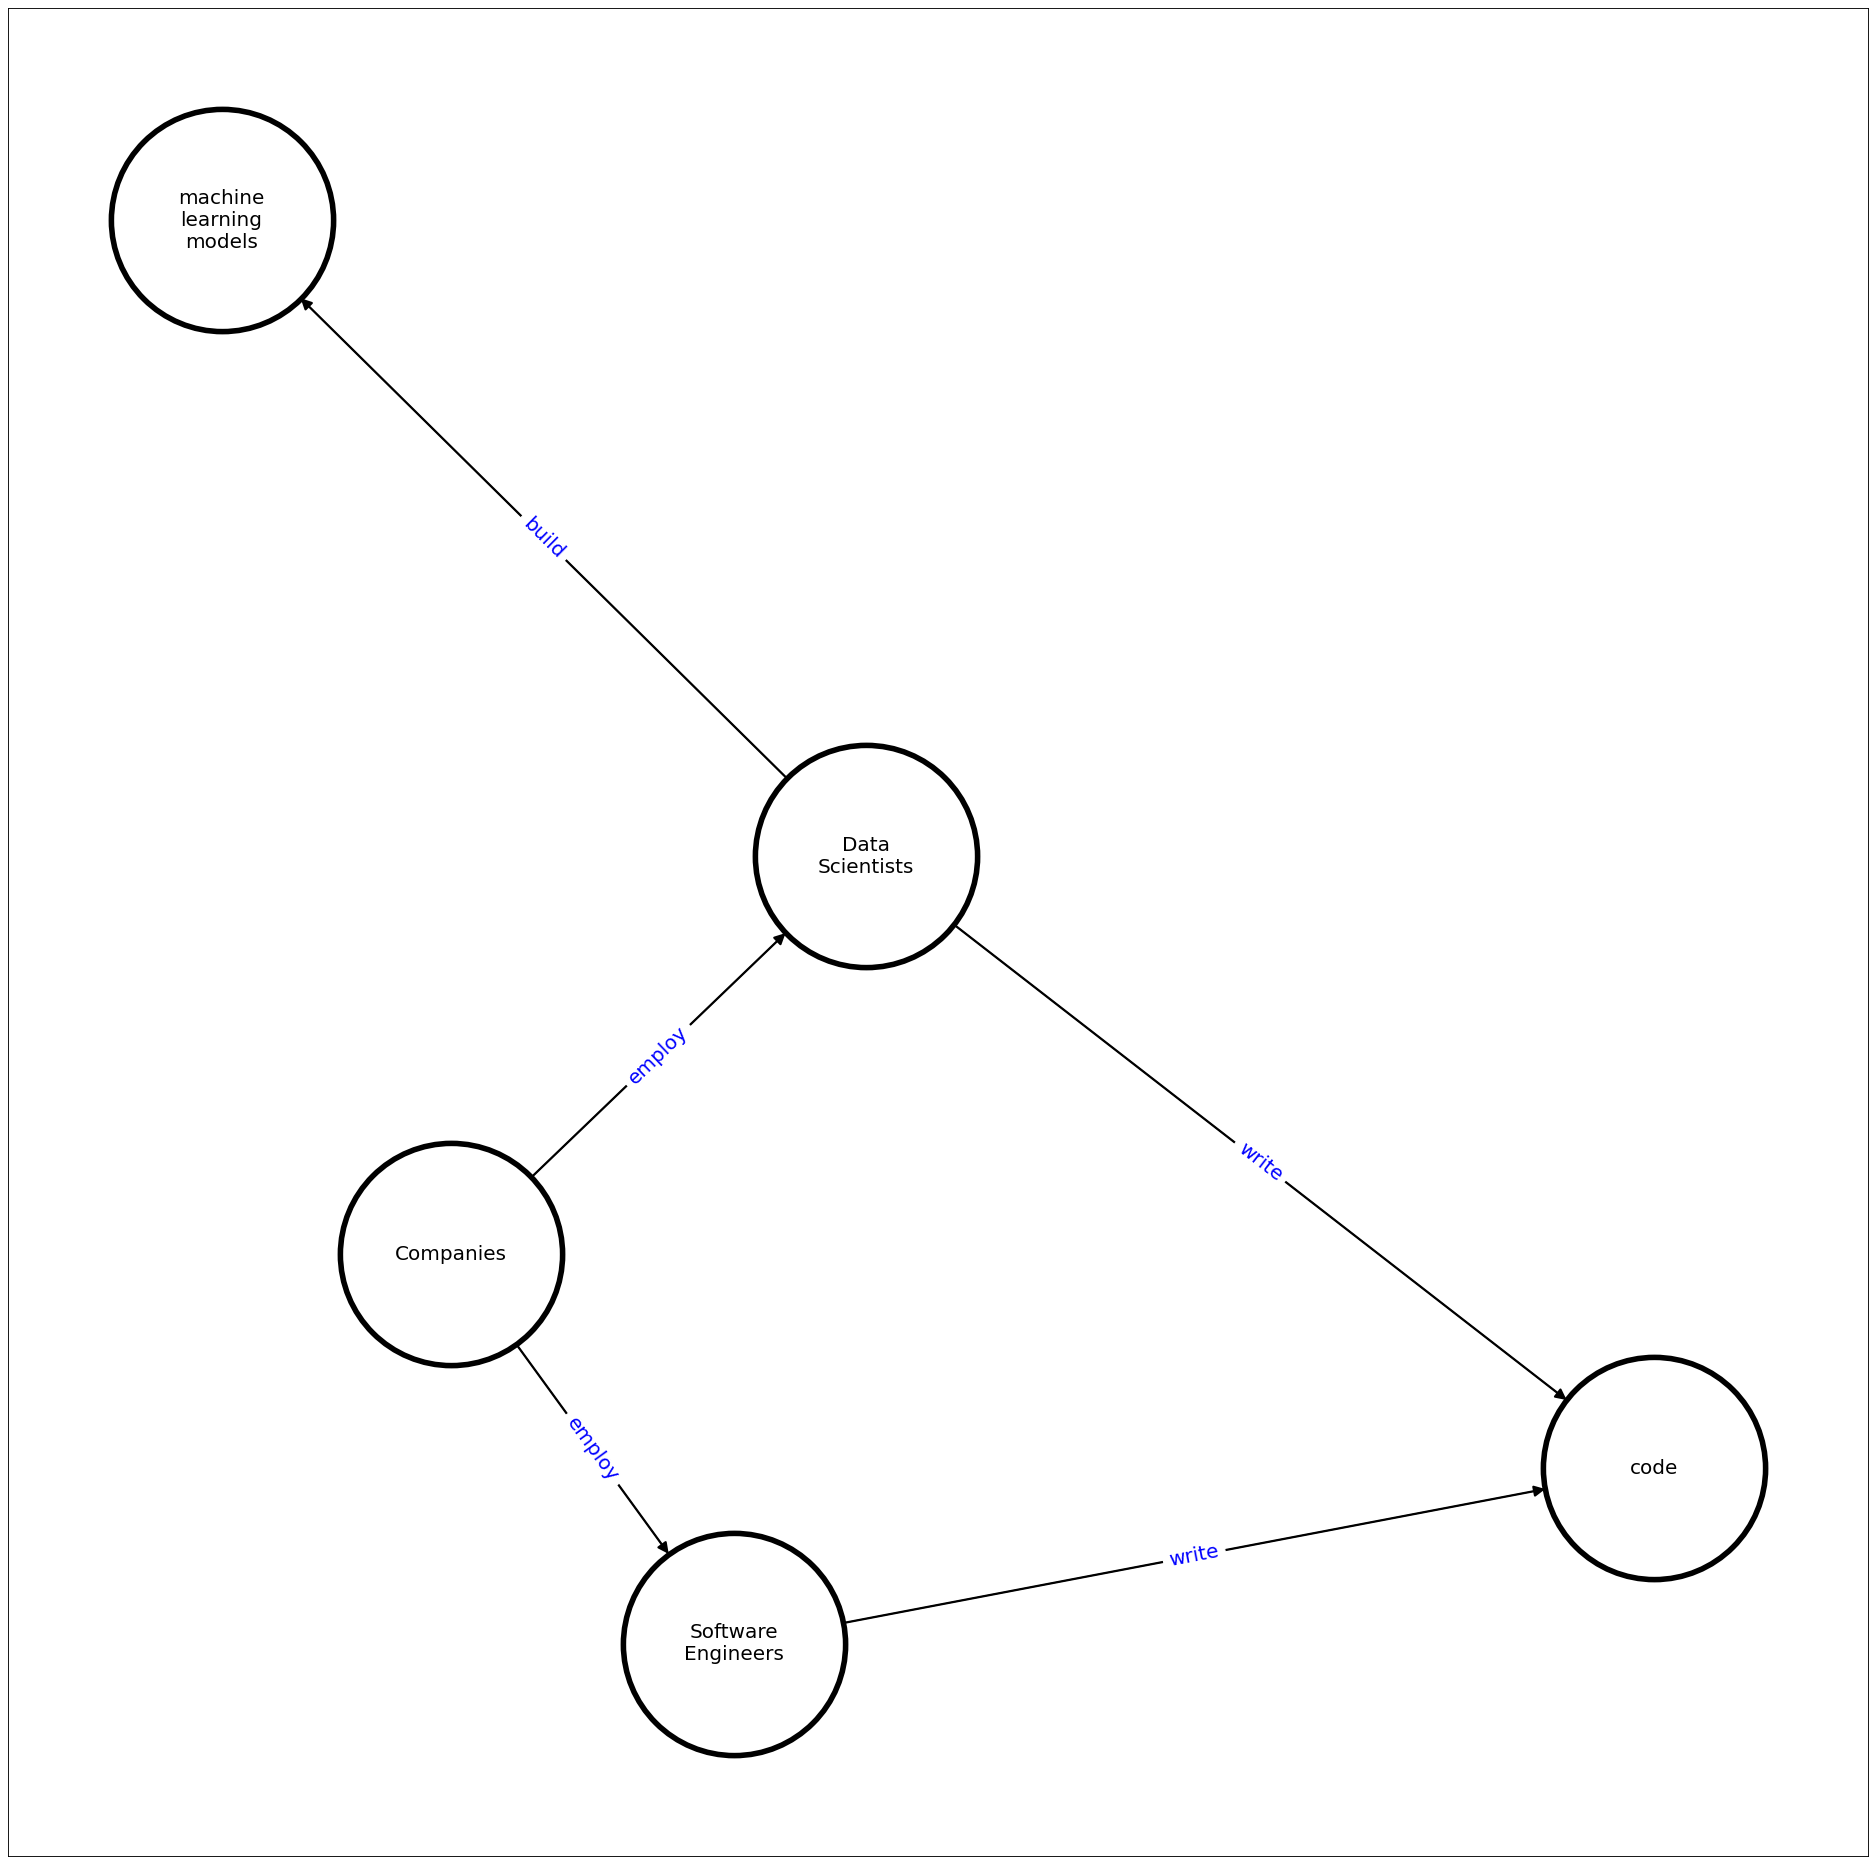

In [12]:
pairs = pandas.DataFrame(graph, columns=['subject', 'relation', 'object'])
draw_knowledge_graph(pairs,40)

## Hearst Patterns

## Listing 5.2
Portions of Listing 5.2 incorporated under the following ASL 2.0 License Notice: [hearst.NOTICE.txt](licenses/hearst.NOTICE.txt)

In [6]:
simple_hearst_patterns = [
    (  '(NP_\\w+ (, )?such as (NP_\\w+ ?(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(such NP_\\w+ (, )?as (NP_\\w+ ?(, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?other NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?include (NP_\\w+ ?(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?especially (NP_\\w+ ?(, )?(and |or )?)+)',
        'first'
    ),
]

In [7]:
extended_hearst_patterns = [
    (
        '((NP_\\w+ ?(, )?)+(and |or )?any other NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?some other NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?be a NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?like (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        'such (NP_\\w+ (, )?as (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?like other NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?one of the NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?one of these NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?one of those NP_\\w+)',
        'last'
    ),
    (
        'example of (NP_\\w+ (, )?be (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?be example of NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?for example (, )?'
        '(NP_\\w+ ?(, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?which be call NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?which be name NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?mainly (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?mostly (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?notably (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?particularly (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?principally (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?in particular (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?except (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?other than (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?e.g. (, )?(NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ \\( (e.g.|i.e.) (, )?(NP_\\w+ ? (, )?(and |or )?)+'
        '(\\. )?\\))',
        'first'
    ),
    (
        '(NP_\\w+ (, )?i.e. (, )?(NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and|or)? a kind of NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and|or)? kind of NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and|or)? form of NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?which look like NP_\\w+)',
        'last'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?which sound like NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?which be similar to (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?example of this be (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?type (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )? NP_\\w+ type)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?whether (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(compare (NP_\\w+ ?(, )?)+(and |or )?with NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?compare to (NP_\\w+ ? (, )?(and |or )?)+)',
        'first'
    ),
    (
        '(NP_\\w+ (, )?among -PRON- (NP_\\w+ ? '
        '(, )?(and |or )?)+)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and |or )?as NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )? (NP_\\w+ ? (, )?(and |or )?)+ '
        'for instance)',
        'first'
    ),
    (
        '((NP_\\w+ ?(, )?)+(and|or)? sort of NP_\\w+)',
        'last'
    ),
    (
        '(NP_\\w+ (, )?which may include (NP_\\w+ '
        '?(, )?(and |or )?)+)',
        'first'
    )
]

In [8]:
class HearstPatterns(object):

    def __init__(self, extended=True):

        self.__adj_stopwords = [
            'able', 'available', 'brief', 'certain',
            'different', 'due', 'enough', 'especially', 'few', 'fifth',
            'former', 'his', 'howbeit', 'immediate', 'important', 'inc',
            'its', 'last', 'latter', 'least', 'less', 'likely', 'little',
            'many', 'ml', 'more', 'most', 'much', 'my', 'necessary',
            'new', 'next', 'non', 'old', 'other', 'our', 'ours', 'own',
            'particular', 'past', 'possible', 'present', 'proud', 'recent',
            'same', 'several', 'significant', 'similar', 'such', 'sup', 'sure'
        ]

        # now define the Hearst patterns
        # format is <hearst-pattern>, <general-term>
        # so, what this means is that if you apply the first pattern,
        # the first Noun Phrase (NP)
        # is the general one, and the rest are specific NPs
        self.__hearst_patterns = simple_hearst_patterns

        if extended:
            self.__hearst_patterns.extend(extended_hearst_patterns)

        self.__spacy_nlp = lang_model

    def chunk(self, rawtext):
        doc = self.__spacy_nlp(rawtext)
        chunks = []
        for sentence in doc.sents:
            sentence_text = sentence.lemma_
            for chunk in sentence.noun_chunks:
                if chunk.lemma_.lower() == "example":
                    start = chunk.start
                    pre_token = sentence[start - 1].lemma_.lower()
                    post_token = sentence[start + 1].lemma_.lower()
                    if start > 0 and \
                            (pre_token == "for" or post_token == "of"):
                        continue
                if chunk.lemma_.lower() == "type":
                    continue
                chunk_arr = []
                replace_arr = []
                #print("chunk:", chunk)
                for token in chunk:
                    if token.lemma_ in self.__adj_stopwords + ["i.e.", "e.g."]:
                        continue
                    chunk_arr.append(token.lemma_)
                    # Remove punctuation and stopword adjectives
                    # (generally quantifiers of plurals)
                    if token.lemma_.isalnum():
                        replace_arr.append(token.lemma_)
                    else:
                        replace_arr.append(''.join(
                            char for char in token.lemma_ if char.isalnum()
                        ))
                if len(chunk_arr) == 0:
                    chunk_arr.append(chunk[-1].lemma_)
                chunk_lemma = ' '.join(chunk_arr)
                replacement_value = 'NP_' + '_'.join(replace_arr)
                if chunk_lemma:
                    sentence_text = re.sub(r'\b%s\b' % re.escape(chunk_lemma),
                                           r'%s' % replacement_value,
                                           sentence_text)
            chunks.append(sentence_text)
        return chunks

    """
        This is the main entry point for this code.
        It takes as input the rawtext to process and returns a list
        of tuples (specific-term, general-term)
        where each tuple represents a hypernym pair.
    """
    def find_hyponyms(self, rawtext):

        hyponyms = []
        np_tagged_sentences = self.chunk(rawtext)

        for sentence in np_tagged_sentences:
            # two or more NPs next to each other should be merged
            # into a single NP, it's a chunk error

            for (hearst_pattern, parser) in self.__hearst_patterns:
                matches = re.search(hearst_pattern, sentence)
                if matches:
                    match_str = matches.group(0)

                    nps = [a for a in match_str.split() if a.startswith("NP_")]

                    if parser == "first":
                        general = nps[0]
                        specifics = nps[1:]
                    else:
                        general = nps[-1]
                        specifics = nps[:-1]

                    for i in range(len(specifics)):
                        pair = (
                            self.clean_hyponym_term(specifics[i]),
                            self.clean_hyponym_term(general)
                        )
                        # reduce duplicates
                        if pair not in hyponyms:
                            hyponyms.append(pair)

        return hyponyms

    def clean_hyponym_term(self, term):
        # good point to do the stemming or lemmatization
        return term.replace("NP_", "").replace("_", " ").replace(",", "")

In [9]:
h = HearstPatterns()
hyps1 = h.find_hyponyms("Many data scientists have skills such as machine learning, python, deep learning, apache spark, among  others.")
hyps2 = h.find_hyponyms("Job candidates most prefer job benefits such as commute time, company culture, and compensation.")
hyps3 = h.find_hyponyms("Google, Apple, or other tech companies might sponsor the conference.")
hyps4 = h.find_hyponyms("Big cities such as San Francisco, Miami, and New York often appeal to new graduates. ")
hyps5 = h.find_hyponyms("Job roles such as Software Engineer, Registered Nurse, and DevOps Engineer are in high demand. ")
hyps6 = h.find_hyponyms("There are job benefits including health insurance and pto. ")
print(hyps1,'\n', hyps2,'\n', hyps3,'\n', hyps4,'\n', hyps5,'\n', hyps6)


[('machine learning', 'skill'), ('python', 'skill'), ('deep learning', 'skill'), ('apache spark', 'skill')] 
 [('commute time', 'job benefit'), ('company culture', 'job benefit'), ('compensation', 'job benefit')] 
 [('Google', 'tech company'), ('Apple', 'tech company')] 
 [('San Francisco', 'big city'), ('Miami', 'big city'), ('New York', 'big city')] 
 [('Software Engineer', 'Job role'), ('Registered Nurse', 'Job role'), ('DevOps Engineer', 'Job role')] 
 [('health insurance', 'job benefit'), ('pto', 'job benefit')]


## Listing 5.3

In [10]:
text_content = """
Many data scientists have skills such as machine learning, python, deep learning, apache spark, among  others. 
Job candidates most prefer job benefits such as commute time, company culture, and compensation. 
Google, Apple, or other tech companies might sponsor the conference. 
Big cities such as San Francisco, Miami, and New York often appeal to new graduates. 
Job roles such as Software Engineer, Registered Nurse, and DevOps Engineer are in high demand. 
There are job benefits including health insurance and pto. 
"""

extracted_relationships = h.find_hyponyms(text_content)

facts = list()
for pair in extracted_relationships:
    facts.append([pair[0], "is_a", pair[1]])

print(*facts, sep="\n")

['machine learning', 'is_a', 'skill']
['python', 'is_a', 'skill']
['deep learning', 'is_a', 'skill']
['apache spark', 'is_a', 'skill']
['commute time', 'is_a', 'job benefit']
['company culture', 'is_a', 'job benefit']
['compensation', 'is_a', 'job benefit']
['Google', 'is_a', 'tech company']
['Apple', 'is_a', 'tech company']
['San Francisco', 'is_a', 'big city']
['Miami', 'is_a', 'big city']
['New York', 'is_a', 'big city']
['Software Engineer', 'is_a', 'Job role']
['Registered Nurse', 'is_a', 'Job role']
['DevOps Engineer', 'is_a', 'Job role']
['health insurance', 'is_a', 'job benefit']
['pto', 'is_a', 'job benefit']


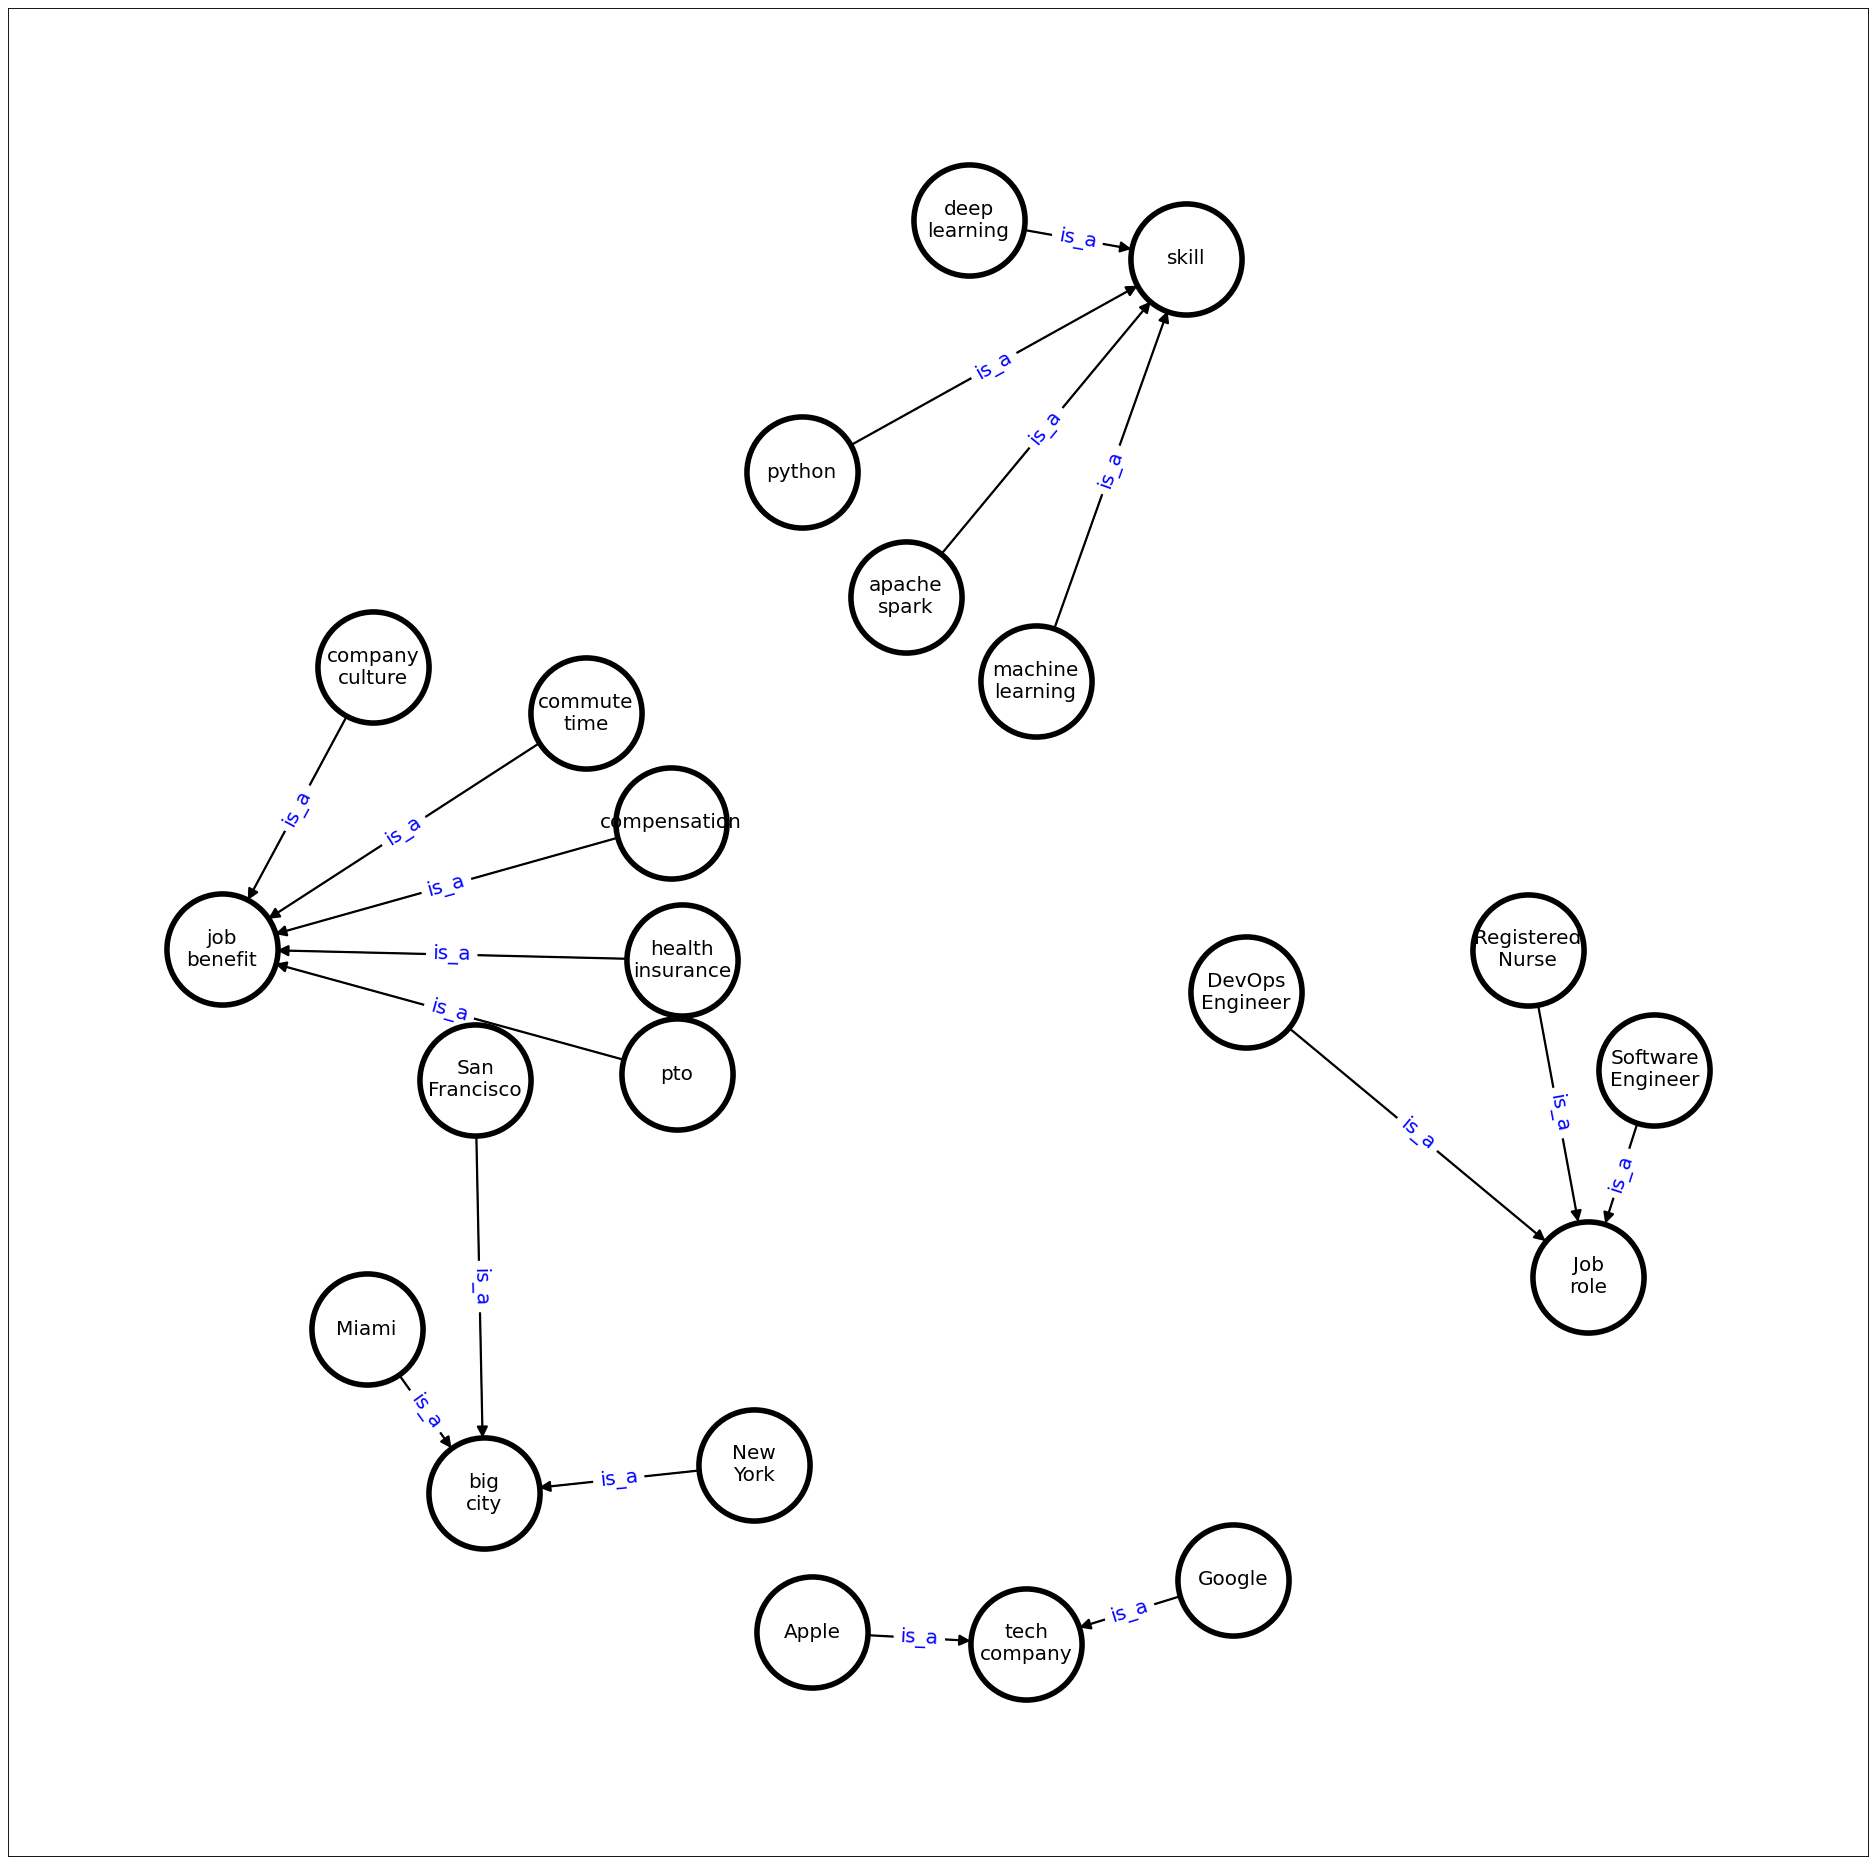

In [11]:
pairs = pandas.DataFrame(facts, columns=['subject', 'relation', 'object'])
draw_knowledge_graph(pairs, 10)

## Success!

You've successfully extracted knowledge graphs both with arbitrary relationships within text and from more well-defined hypernym relationships. In the next section, we'll index some large text datasets that we can use to as the basis for a more dynamic kind of knowledge graph - a Semantic Knowlege Graph.


Up Next: [Setting up the Knowledge Graph Datasets](2.index-datasets.ipynb)